# Random Models

In this experiment, I conduct a series of sensitivity analyses. I conduct two experiments: in one, the only source of stochasticity is conflicts; in the other, I also perturb all the starting values.

In [75]:
import copy
from collections import defaultdict, namedtuple
import random
import pickle

import numpy as np
import scipy.stats
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
#plt.style.use('bmh')

In [2]:
from negotiation_model import *
from bdm_agent import *
from bdm_replication import *


In [3]:
params = {
    "font.family": 'serif',
    "font.serif": ["Computer Modern"],
    'text.usetex': True,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'axes.labelsize': 14

   }
plt.rcParams.update(params)

# Generate 100 starting cases

In [17]:
N = 100 # Number of cases
n = 10 # Agents per case
all_df = []
for i in range(N):
    capabilities = [random.random() for _ in range(n)]
    saliences = [random.random() for _ in range(n)]
    positions = [random.random() for _ in range(n)]
    df = pd.DataFrame({"Name": [str(j) for j in range(n)], "Capability": capabilities,
                      "Salience": saliences, "Position": positions})
    df["Instantiation"] = i
    all_df.append(df)
df = pd.concat(all_df)

In [19]:
def make_model(agent_df):
    agents = []
    for i, row in agent_df.iterrows():
        name = row.Name
        capability = row.Capability
        position = row.Position
        salience = row.Salience
        new_agent = BDMActor(name, capability, position, salience)
        new_agent.decision_model.Q = 0.5
        new_agent.decision_model.T = 0.5
        agents.append(new_agent)
    model = Real_Negotiation_Model(agents)
    return model

In [20]:
for i, group in df.groupby("Instantiation"):
    m = make_model(group)
    break

In [21]:
m.run_model(10)

## Run each model 100 times

In [23]:
all_models = []
for i, group in df.groupby("Instantiation"):
    base_model = make_model(group)
    outcomes = []
    models = []
    for j in range(100):
        model = copy.deepcopy(base_model)
        model.run_model(10)
        outcomes.append(model.find_median())
        models.append(model)
    all_models.append(models)

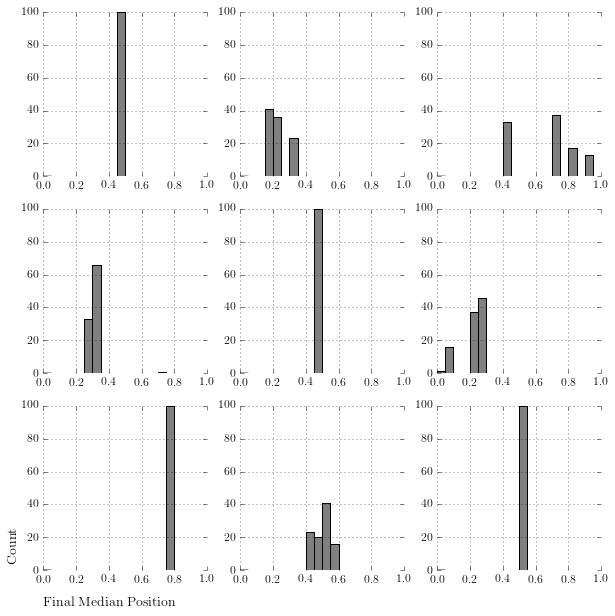

In [34]:
fig = plt.figure(figsize=(10,10))
for i, models in enumerate(all_models[:9]):
    outcomes = [m.find_median() for m in models]
    ax = fig.add_subplot(3, 3, i+1)
    ax.set_xlim(0,1)
    ax.set_ylim(0,100)
    ax.hist(outcomes, bins=np.linspace(0,1,21), color='grey')
    ax.grid(True)
    
    for spine in ["top", "left", "right", "bottom"]:
        ax.spines[spine].set_visible(False)

fig.text(0.125, 0.075, "Final Median Position", fontsize=14)
fig.text(0.075, 0.17, "Count", fontsize=14, rotation="vertical")
#fig.tight_layout()

In [35]:
PATH = "/Users/dmasad/Documents/Dissertation/Dissertation/BDM_Reproduction/Figures/"
fig.savefig(PATH + "RandomGamesHist1.pdf")

In [30]:
# Store all outputs
all_df = []
for i, models in enumerate(all_models):
    runs = [j for j in range(len(models))]
    outcomes = [m.find_median() for m in models]
    m_df = pd.DataFrame({"Run": runs, "Median": outcomes})
    m_df["Instantiation"] = i
    all_df.append(m_df)
ex1_medians = pd.concat(all_df)

27


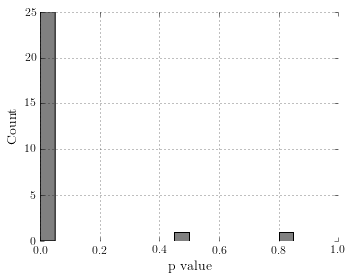

In [25]:
all_pvals = []
for model_set in all_models:
    outcomes = [m.find_median() for m in model_set]
    _, p_val = scipy.stats.mstats.normaltest(outcomes)
    if not np.ma.is_masked(p_val):
        all_pvals.append(p_val)
#plt.hist(all_pvals)

fig, ax = plt.subplots(figsize=(5, 4))
ax.hist(all_pvals, bins=np.linspace(0, 1, 21), color='grey')
for spine in ["top", "left", "right", "bottom"]:
    ax.spines[spine].set_visible(False)
ax.grid(True)
ax.set_xlabel("p value")
ax.set_ylabel("Count")
fig.tight_layout()
print(len(all_pvals))

In [33]:
PATH = "/Users/dmasad/Documents/Dissertation/Dissertation/BDM_Reproduction/Figures/"
fig.savefig(PATH + "RandomGamesPVals1.pdf")

NameError: name 'PATH' is not defined

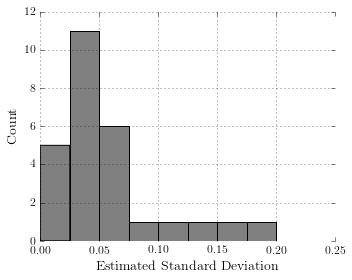

In [28]:
all_sigmas = []
for model_set in all_models:
    outcomes = [m.find_median() for m in model_set]
    _, p_val = scipy.stats.mstats.normaltest(outcomes)
    if np.ma.is_masked(p_val):
        continue
    all_sigmas.append(np.std(outcomes))

fig, ax = plt.subplots(figsize=(5, 4))
ax.hist(all_sigmas, bins=np.linspace(0, 0.25, 11), color='grey')
ax.grid(True)
ax.set_xlabel("Estimated Standard Deviation")
ax.set_ylabel("Count")

for spine in ["top", "left", "right", "bottom"]:
    ax.spines[spine].set_visible(False)
fig.tight_layout()
fig.savefig(PATH + "RandomGamesSD1.pdf")

#plt.hist(all_sigmas)

In [39]:
scipy.stats.mstats.normaltest(all_sigmas)

(15.557501176706852, 0.00041853477029096402)

# Perturb and Run

In [45]:
def perturb_var(x, sd=0.05):
    new_x = x + random.normalvariate(0, sd)
    new_x = max(0, min(1, new_x))
    return new_x

In [48]:
def make_model_perturbed(agent_df):
    agents = []
    for i, row in agent_df.iterrows():
        name = row.Name
        capability = perturb_var(row.Capability)
        position = perturb_var(row.Position)
        salience = perturb_var(row.Salience)
        new_agent = BDMActor(name, capability, position, salience)
        new_agent.decision_model.Q = 0.5
        new_agent.decision_model.T = 0.5
        agents.append(new_agent)
    model = Real_Negotiation_Model(agents)
    return model

In [54]:
all_models_2 = []
for i, group in df.groupby("Instantiation"):
    outcomes_2 = []
    models_2 = []
    for j in range(100):
        model = make_model_perturbed(group)
        model.run_model(10)
        outcomes_2.append(model.find_median())
        models_2.append(model)
    all_models_2.append(models_2)

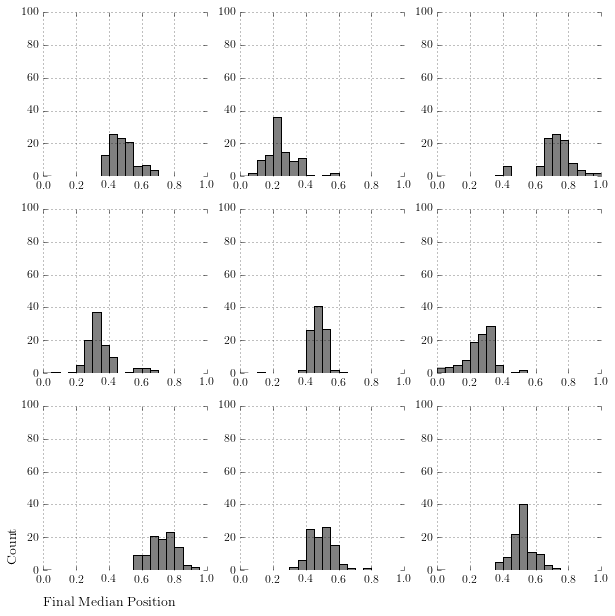

In [61]:
fig = plt.figure(figsize=(10,10))
for i, models in enumerate(all_models_2[:9]):
#for i, models in enumerate(all_models_2[-9:]):
    outcomes = [m.find_median() for m in models]
    ax = fig.add_subplot(3, 3, i+1)
    ax.set_xlim(0,1)
    ax.set_ylim(0,100)
    ax.hist(outcomes, bins=np.linspace(0,1,21), color='grey')
    ax.grid(True)
    
    for spine in ["top", "left", "right", "bottom"]:
        ax.spines[spine].set_visible(False)

fig.text(0.125, 0.075, "Final Median Position", fontsize=14)
fig.text(0.075, 0.17, "Count", fontsize=14, rotation="vertical")
#fig.tight_layout()
fig.savefig(PATH + "RandomGamesHist2.pdf")

In [56]:
# Store all outputs
all_df = []
for i, models in enumerate(all_models_2):
    runs = [j for j in range(len(models))]
    outcomes = [m.find_median() for m in models]
    m_df = pd.DataFrame({"Run": runs, "Median": outcomes})
    m_df["Instantiation"] = i
    all_df.append(m_df)
ex2_medians = pd.concat(all_df)

100


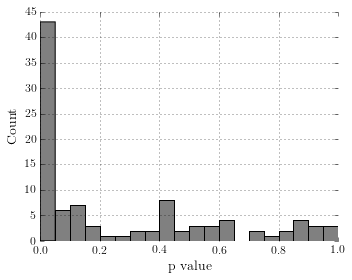

In [57]:
all_pvals = []
for model_set in all_models_2:
    outcomes = [m.find_median() for m in model_set]
    _, p_val = scipy.stats.mstats.normaltest(outcomes)
    if not np.ma.is_masked(p_val):
        all_pvals.append(p_val)
#plt.hist(all_pvals)

fig, ax = plt.subplots(figsize=(5, 4))
ax.hist(all_pvals, bins=np.linspace(0, 1, 21), color='grey')
for spine in ["top", "left", "right", "bottom"]:
    ax.spines[spine].set_visible(False)
ax.grid(True)
ax.set_xlabel("p value")
ax.set_ylabel("Count")
fig.tight_layout()
print(len(all_pvals))

PATH = "/Users/dmasad/Documents/Dissertation/Dissertation/BDM_Reproduction/Figures/"
fig.savefig(PATH + "RandomGamesPVals2.pdf")

In [44]:
len([p for p in all_pvals if p<0.01])

89

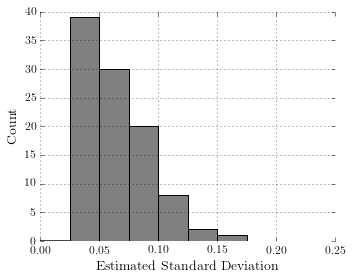

In [60]:
all_sigmas = []
for model_set in all_models_2:
    outcomes = [m.find_median() for m in model_set]
    _, p_val = scipy.stats.mstats.normaltest(outcomes)
    if np.ma.is_masked(p_val):
        continue
    all_sigmas.append(np.std(outcomes))

fig, ax = plt.subplots(figsize=(5, 4))
ax.hist(all_sigmas, bins=np.linspace(0, 0.25, 11), color='grey')

ax.grid(True)
ax.set_xlabel("Estimated Standard Deviation")
ax.set_ylabel("Count")

for spine in ["top", "left", "right", "bottom"]:
    ax.spines[spine].set_visible(False)
fig.tight_layout()
fig.savefig(PATH + "RandomGamesSD2.pdf")


## Compare standard deviations

In [65]:
ex1_medians.head()

,Median,Run,Instantiation
0,0.460394,0,0
1,0.460394,1,0
2,0.460394,2,0
3,0.460394,3,0
4,0.460394,4,0


In [64]:
ex2_medians.head()

,Median,Run,Instantiation
0,0.388504,0,0
1,0.434006,1,0
2,0.370498,2,0
3,0.600129,3,0
4,0.516305,4,0


In [69]:
ex1_means = ex1_medians.groupby("Instantiation")["Median"].aggregate("mean")
ex2_means = ex2_medians.groupby("Instantiation")["Median"].aggregate("mean")
mean_comparison = pd.DataFrame({"Experiment 1": ex1_means, "Experiment 2": ex2_means})

In [80]:
ex1_sd = ex1_medians.groupby("Instantiation")["Median"].aggregate(np.std).fillna(0)
ex2_sd = ex2_medians.groupby("Instantiation")["Median"].aggregate(np.std)
sd_comparison = pd.DataFrame({"Experiment 1": ex1_sd, "Experiment 2": ex2_sd})

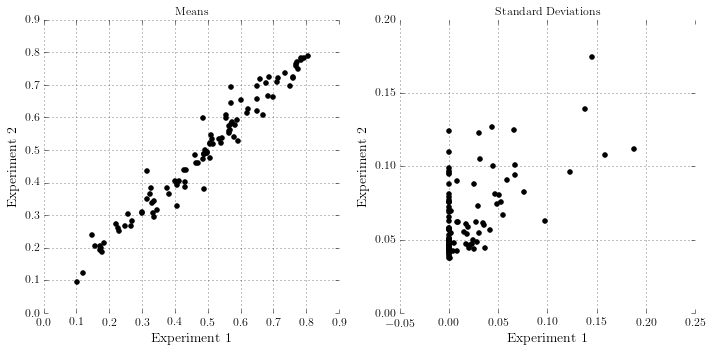

In [87]:
fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

mean_comparison.plot(x="Experiment 1", y="Experiment 2", kind='scatter', c='k', ax=ax1)
ax1.set_title("Means")

sd_comparison.plot(x="Experiment 1", y="Experiment 2", kind='scatter', c='k', ax=ax2)
ax2.set_title("Standard Deviations")
ax2.set_ylim(0, )

for ax in [ax1, ax2]:
    for spine in ["top", "left", "right", "bottom"]:
        ax.spines[spine].set_visible(False)
    ax.grid(True)
fig.tight_layout()
PATH = "/Users/dmasad/Documents/Dissertation/Dissertation/BDM_Reproduction/Figures/"
fig.savefig(PATH + "RandomGamesComparison.pdf")

In [76]:
with open("Sensitivity_Results.pickle", "wb") as f:
    pickle.dump((ex1_medians, ex2_medians), f)

In [82]:
sd_comparison.corr()

,Experiment 1,Experiment 2
Experiment 1,1.000000,0.590932
Experiment 2,0.590932,1.000000


In [88]:
sd_comparison.corr(method='spearman')

,Experiment 1,Experiment 2
Experiment 1,1.000000,0.344045
Experiment 2,0.344045,1.000000
